In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

import plotly.express as px


Data Pre-processing and EDA(Exploratory data analysis)

In [216]:
pd.set_option('display.max_columns', None)

Data Cleaning and filtering data which has firesize <5000 as number of small fires are high.

In [236]:
# Reading the combined CSV files
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')

#Get rid of outliers - fires of size larger than 5000 acres, and there are large number of small fires and other very less number are having the high 
# area of fires, because of which the deviation is very high
df = df.loc[df['fire_size'] < 5000]
df.columns

Index(['fire_name', 'fire_size', 'fire_size_class', 'stat_cause_descr',
       'latitude', 'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [237]:
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)


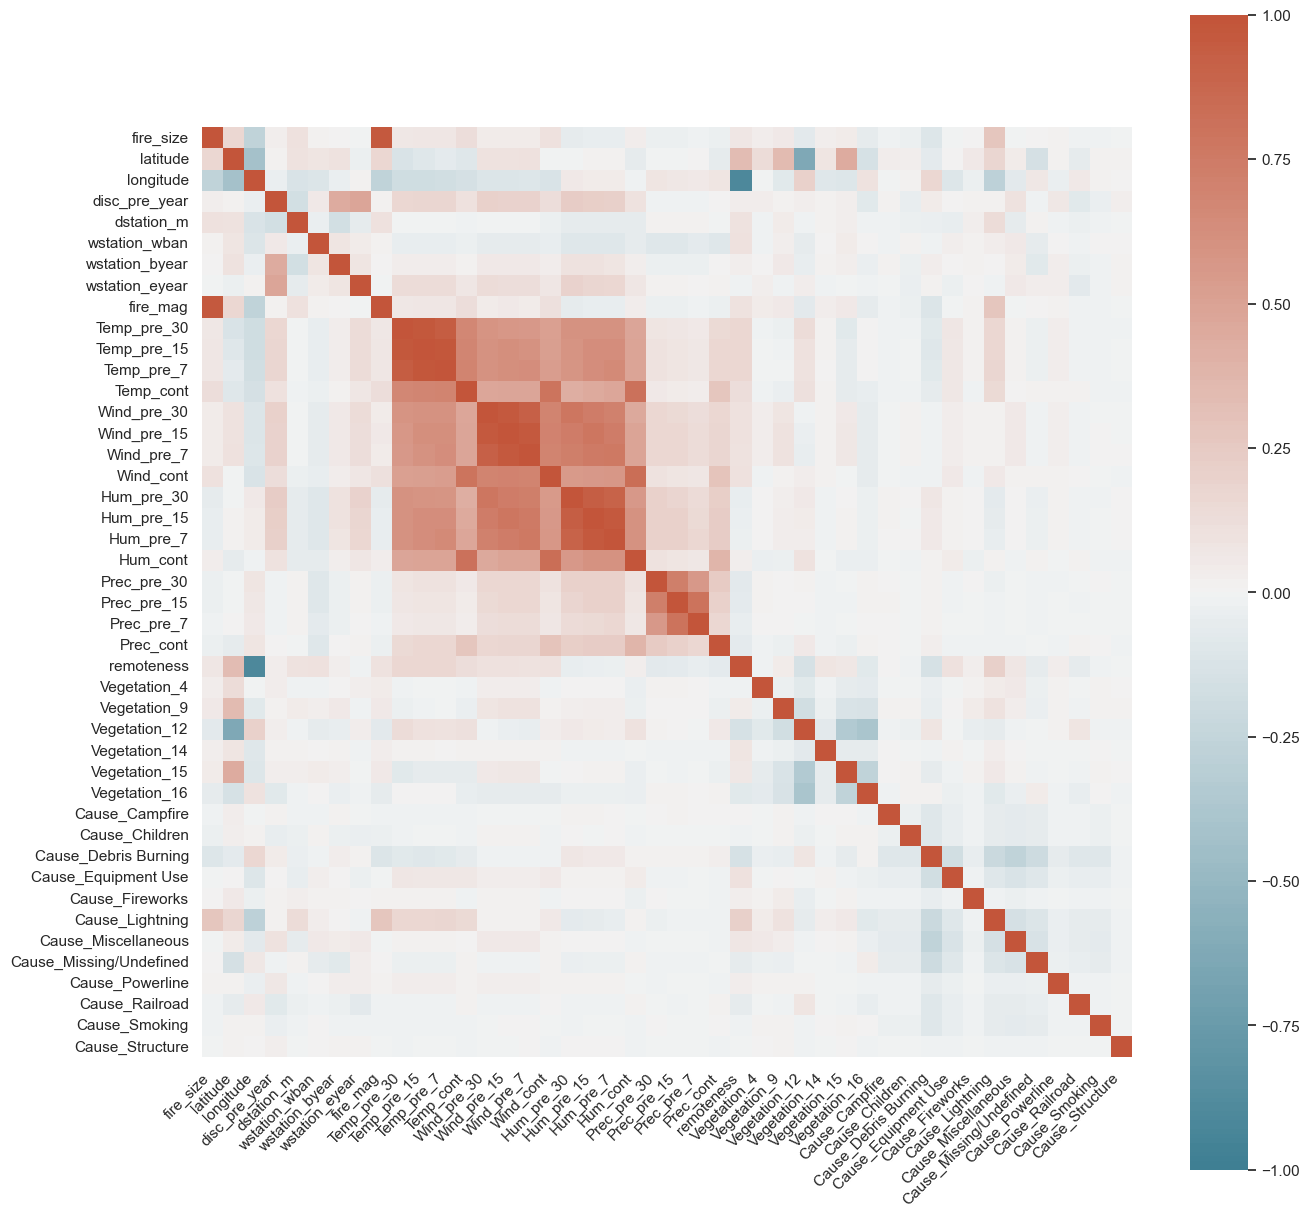

In [238]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,15)})

In [239]:
### Dealing with missing data
print(len(df))

# drop columns where weather_file is missing in the data, as it wont have the weather situation at that time, so its where ever data is 
#missing we can remove those rows as it wont be useful
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

51395
37915


In [240]:
# Weather data has a lot of 0 and values some of which may be missing values,
# Mark '0' values in weather columns as Na (to see how many there are) 
# As 0 wont add any value to the data, we are converting to NA and then removing them which will make data set
subset0 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset0] = df[subset0].replace({0:np.nan, '0':np.nan})
print(len(df))

# Mark '-1' as missing
subset_neg1 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont',])
print(len(df))
# This leaves us with 38,689 observations  +/- 3,000  to work with (originally we had 50,000)

37915
35683


In [241]:
# fill the 'pre' columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill NAs in the date of fire containment based on mean values from previous days
for col in ['Temp','Wind','Hum']:
    df[f'{col}_cont'] = df.apply(
        lambda row: (row[f'{col}_pre_7']+row[f'{col}_pre_15']+row[f'{col}_pre_30'])/3 if np.isnan(row[f'{col}_cont']) else row[f'{col}_cont'],
        axis=1)

        

Experiment data  preparation for the models


# Experiment 1 - which will select all the available  features from the dataset



In [242]:
# Experiment 1 - which will select all teh available  features from the dataset
#Features included - variables related to Vegetation,Temperature, Humidity, Wind, Precipitation, cause of  fire, longitude and latitude
# we have 34 variables  for x-variables  to which we are gonna target one y-variable which is fire_size
# selecting features and target variables
X1 = df[['Vegetation_4','remoteness', 'Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
# X1 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]

y = df['fire_size']

#train test split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
df1 = [X1_train, X1_test, y_train, y_test]



Experiment  type 2 :  Include only long, lat, vegetation, cause and pre- weather data, without cont

In [243]:
# which is the data set where I removed the variables  on which the fire is  containining on the day
# removed 4 variables
# selecting features and target variables
X2 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#train test split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
df2 = [X2_train, X2_test, y_train, y_test]

Experiment 3 - Including only lat, long and weather pre- data

In [244]:
#When I have done the feature importance, I got to know that the cause and vegetation is not that important, so here we removed the 2 
#  selecting features and target variables
X3 = df[['latitude','longitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7']]
y = df['fire_size']

#train test split
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)
df3 = [X3_train, X3_test, y_train, y_test]

Experiment 4 :-  with experiment 1 data with normalization


In [245]:
# have done the minMax normalization for the experiment 1 data frame.

df_4 = df[['Vegetation_4','remoteness','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
names = df_4.columns

# normalizing data
df_4 = preprocessing.normalize(df_4)
scaled_df = pd.DataFrame(df_4, columns=names)

#train test split
X4_train, X4_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.2, random_state=42)
df4 = [X4_train, X4_test, y_train, y_test]

Modelling  the above experiments with different models like  decision tree,gradient bosting, random  forest


Decision Tree - Experiment 1


In [179]:
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(df1[0], df1[2])

predictions = dectr.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 94.29199963430013
R Squared: 0.7398227084553771



Gradient Boosting - Experiment 1



In [180]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(df1[0], df1[2])

predictions = gr_boost.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))


Mean Absolute Error: 97.53450327321218
R Squared: 0.8153427399692896


In [248]:
rf = RandomForestRegressor()
rf.fit(df1[0], df1[2])

predictions = rf.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))


Mean Absolute Error: 86.16588209386764
R Squared: 0.8577230338262292


Modelling experirments 


In [182]:
# less than 5000
for model in [DecisionTreeRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]:
    for idx,df in enumerate([df1, df2, df3, df4]):
        model.fit(df[0], df[2])
        print(f'{model}; Experiment {idx+1}; Mean Absolute Error:', metrics.mean_absolute_error(df[3], model.predict(df[1])))
        print(f'{model}; Experiment {idx+1}; R Squared:', metrics.r2_score(df[3], model.predict(df[1])))
        print('')


DecisionTreeRegressor(); Experiment 1; Mean Absolute Error: 94.56786764186633
DecisionTreeRegressor(); Experiment 1; R Squared: 0.7301468267522166

DecisionTreeRegressor(); Experiment 2; Mean Absolute Error: 255.94452939890706
DecisionTreeRegressor(); Experiment 2; R Squared: -0.47239294531128206

DecisionTreeRegressor(); Experiment 3; Mean Absolute Error: 270.7379522726636
DecisionTreeRegressor(); Experiment 3; R Squared: -0.6008382513267048

DecisionTreeRegressor(); Experiment 4; Mean Absolute Error: 264.73709389519405
DecisionTreeRegressor(); Experiment 4; R Squared: -0.5531023578699934

GradientBoostingRegressor(); Experiment 1; Mean Absolute Error: 97.58264866713458
GradientBoostingRegressor(); Experiment 1; R Squared: 0.8152716100405656

GradientBoostingRegressor(); Experiment 2; Mean Absolute Error: 251.8802025040535
GradientBoostingRegressor(); Experiment 2; R Squared: 0.17051024249178548

GradientBoostingRegressor(); Experiment 3; Mean Absolute Error: 257.4606757869463
Gradien

The best performing basemodel is the Random Forest algorithm with R2 of 23%. This is the model we will use for further analysis and improvement.


Fetaure Importance

What features are the most influential in the model?

In [249]:
feature_importances = pd.DataFrame(rf.feature_importances_,
    index = df1[0].columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
remoteness,0.754056
longitude,0.101660
latitude,0.026129
Hum_cont,0.014771
Wind_cont,0.010837
Temp_cont,0.008119
Temp_pre_7,0.008044
Temp_pre_30,0.007980
Hum_pre_15,0.006967
Hum_pre_30,0.006862




Reevaluate model after deleting least important features


In [250]:
# # selecting features and target variables
# X = df[['Vegetation_9','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Lightning','longitude']]

# #train test split
# X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Random Forest Regressor 
# rf_reg = RandomForestRegressor()

# # fit the regressor with x and y data
# rf_reg.fit(X2_train, y2_train)

# predictions = rf_reg.predict(X2_test)
# print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, predictions))
# print('R Squared:', metrics.r2_score(y2_test, predictions))


Mean Absolute Error: 238.968321418684
R Squared: 0.24333718179284403


Hyper-parameter tuning 

In [191]:
rf_reg = RandomForestRegressor()
search_grid={'n_estimators':[50,100,200],'max_depth':[2,5,8,10]}
search=GridSearchCV(estimator=rf_reg,param_grid=search_grid,scoring='neg_mean_absolute_error',n_jobs=1,cv=5, verbose=1)
search.fit(df1[0], df1[2])
print(search.best_score_)
print(search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
-80.306416020498
{'max_depth': 10, 'n_estimators': 200}


In [251]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 200, max_depth=10)

# fit the regressor with x and y data
rf_reg.fit(df1[0], df1[2])

predictions = rf_reg.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 83.50171356666195
R Squared: 0.8533604377393926


In [253]:
X = df[['Vegetation_9','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Lightning','longitude']]
y = df['fire_size']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Neural network model


In [254]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [255]:
X_train.shape

(28546, 20)

In [256]:
model = Sequential([
    #normalizer,
    Dense(34, activation="relu", kernel_regularizer = regularizers.l2(0.01), kernel_initializer='normal',input_dim = X_train.shape[1]),
    Dense(34, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(64, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(32, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy','mae']
)

In [198]:
history = model.fit(
    X_train,
    y_train,
    epochs=150,
    validation_split=0.15,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=20,
        mode='min',
        restore_best_weights=True
    )]
)

Epoch 1/150
759/759 [==============================] - 1s 1ms/step - loss: 487235.3125 - accuracy: 0.2167 - mae: 257.7435 - val_loss: 484998.4688 - val_accuracy: 0.2167 - val_mae: 241.1130
Epoch 2/150
759/759 [==============================] - 1s 1ms/step - loss: 472589.2812 - accuracy: 0.2171 - mae: 259.1883 - val_loss: 479511.8125 - val_accuracy: 0.2167 - val_mae: 238.4337
Epoch 3/150
759/759 [==============================] - 1s 1ms/step - loss: 469659.5625 - accuracy: 0.2165 - mae: 256.8068 - val_loss: 470249.8125 - val_accuracy: 0.2167 - val_mae: 262.8446
Epoch 4/150
759/759 [==============================] - 1s 1ms/step - loss: 465675.0000 - accuracy: 0.2171 - mae: 255.3619 - val_loss: 471215.3125 - val_accuracy: 0.2167 - val_mae: 228.4272
Epoch 5/150
759/759 [==============================] - 1s 1ms/step - loss: 464156.9375 - accuracy: 0.2171 - mae: 254.2477 - val_loss: 461401.7812 - val_accuracy: 0.2167 - val_mae: 243.0974
Epoch 6/150
759/759 [==============================] - 

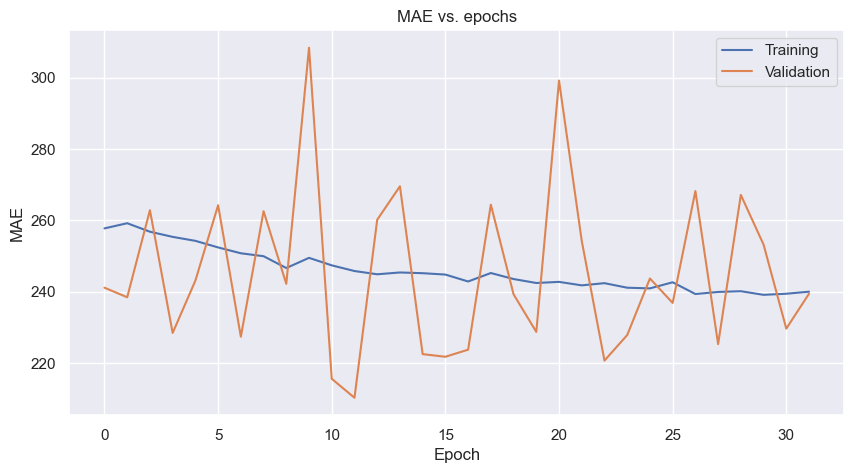

In [257]:

historydf = pd.DataFrame(history.history)

#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['mae'],label='mae')
plt.plot(historydf['val_mae'],label='val_mae')
plt.title('MAE vs. epochs')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [258]:
test_loss, test_acc, test_mae = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Mean Absolute Error: {acc:0.3f}'.format(acc=test_mae))
print('accuracy: {acc:0.3f}'.format(acc=test_acc))
print('loss: {acc:0.3f}'.format(acc=test_loss))

Mean Absolute Error: 174.660
accuracy: 0.002
loss: 583550.812


In [226]:
print(f"Average Fire Size: {df.fire_size.mean()}")
print(f"Standard Deviation of Fire Size: {df.fire_size.std()}")


Average Fire Size: 154.1552388648702
Standard Deviation of Fire Size: 701.5348176560531


Classification:


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51395 entries, 0 to 55365
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fire_name         22043 non-null  object        
 1   fire_size         51395 non-null  float64       
 2   fire_size_class   51395 non-null  object        
 3   stat_cause_descr  51395 non-null  object        
 4   latitude          51395 non-null  float64       
 5   longitude         51395 non-null  float64       
 6   state             51395 non-null  object        
 7   disc_clean_date   51395 non-null  datetime64[ns]
 8   discovery_month   51395 non-null  object        
 9   disc_date_pre     51395 non-null  object        
 10  disc_pre_year     51395 non-null  int64         
 11  disc_pre_month    51395 non-null  object        
 12  wstation_usaf     51395 non-null  object        
 13  dstation_m        51395 non-null  float64       
 14  wstation_wban     5139

In [228]:
df.dropna(axis='rows', how='any', inplace=True)
df.head()

,fire_name,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,Vegetation,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
3,WNA 1,1.0,B,Debris Burning,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,0.00000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
9,CRAZY,1.0,B,Miscellaneous,48.839400,-99.718500,ND,2004-04-19,Apr,3/20/2004,2004,Mar,727675,129109.88140,99999,1936,2020,15,0.1,727675-99999-2004.gz,4.600950,6.861878,6.053333,0.00000,6.380760,6.334254,6.645333,0.000000,64.606509,55.943038,54.337838,0.000000,12.3,1.8,0.0,0.0,0.291683
11,SWR-20150212-008,37.0,C,Arson,31.195108,-88.150651,AL,2015-02-12,Feb,1/13/2015,2015,Jan,998196,56031.33313,99999,2008,2020,12,1.0,File Not Found,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.191923
15,ROLSTON,1.0,B,Missing/Undefined,33.988609,-103.135277,NM,1996-02-12,Feb,1/13/1996,1996,Jan,722686,46845.65519,99999,1973,2010,16,0.1,722686-23008-1996.gz,3.523045,2.536364,8.913095,8.39681,6.245931,6.014404,5.798795,6.062726,38.712707,45.180055,40.493976,33.537604,10.0,8.0,0.0,0.0,0.330323
16,TREE HOUSE LIGHTER,1.5,B,Children,36.083300,-78.916700,NC,2001-04-16,Apr,3/17/2001,2001,Mar,722193,23185.42332,3722,1973,2020,0,0.1,File Not Found,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.106035


In [259]:
from sklearn.tree import DecisionTreeClassifier

train_set, test_set = train_test_split(df, test_size=0.30, random_state=568)

print(train_set.info())
print(test_set.info())




<class 'pandas.core.frame.DataFrame'>
Int64Index: 24978 entries, 30145 to 49349
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fire_name                11433 non-null  object        
 1   fire_size                24978 non-null  float64       
 2   fire_size_class          24978 non-null  object        
 3   latitude                 24978 non-null  float64       
 4   longitude                24978 non-null  float64       
 5   state                    24978 non-null  object        
 6   disc_clean_date          24978 non-null  datetime64[ns]
 7   discovery_month          24978 non-null  object        
 8   disc_date_pre            24978 non-null  object        
 9   disc_pre_year            24978 non-null  int64         
 10  disc_pre_month           24978 non-null  object        
 11  wstation_usaf            24978 non-null  object        
 12  dstation_m               249

I am dividing the feature list into 2 parts as we have already done the feature importance.

Why I am selecting features, as we have seen before most fires are based on the natural cause, i want to predict the  based on the climatic conditions

List 1 --> X = "remoteness","latitude" ,"longitude","Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"
List 2 --> X = "Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"

Y = "fire_size_class"

Reason

When I was using "fire_size" for the Y feature, I had gotten continuous value error. Hence, I changed to "fire_size_class" as suggested to using discreate values by creating buckets; which my database already has.


Decision Tree 
Training data 


In [291]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

X = train_set[["remoteness","latitude" ,"longitude","Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
#X = train_set[["Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]

Y = train_set["fire_size"]

#Transforming the "unknown lable continuous variable "error into label encoder and applying for the classification

lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(Y)

tree_classifier = DecisionTreeClassifier().fit(X,y_transformed)
print(tree_classifier)

y_pred = tree_classifier.predict(X)
c_matrix = confusion_matrix(y_transformed, y_pred)
print('The confusion Matrix is: ')
print(c_matrix)


from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
print("The Evalution metrics are as follows: ")
print("Accuracy: ", accuracy_score(y_transformed, y_pred))
print("Precision: ", precision_score(y_transformed, y_pred, average="weighted"))
print("Sensitivity: ", recall_score(y_transformed, y_pred, average="weighted"))
print("F1 Score: ", f1_score(y_transformed, y_pred, average="weighted"))

DecisionTreeClassifier()
The confusion Matrix is: 
[[ 6  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]
The Evalution metrics are as follows: 
Accuracy:  0.9995596124589639
Precision:  0.9995599727734231
Sensitivity:  0.9995596124589639
F1 Score:  0.999559248866279



Gaussian Naive Bayes


In [284]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix

# Training Set

X = train_set[["remoteness","latitude" ,"longitude","Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
#X = train_set[["Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
Y = train_set["fire_size_class"]

gnb = GaussianNB()
print(gnb.fit(X,Y))

y_pred = gnb.predict(X)
c_matrix = confusion_matrix(Y, y_pred)
print("Confusion Metrix: ")
print(c_matrix)

print("The Evalution metrics are as follows: ")
print("Accuracy: ", accuracy_score(Y, y_pred))
print("Precision: ", precision_score(Y, y_pred, average="weighted"))
print("Sensitivity: ", recall_score(Y, y_pred, average="weighted"))
print("F1 Score: ", f1_score(Y, y_pred, average="weighted"))

GaussianNB()
Confusion Metrix: 
[[17261   311     0     0    71]
 [    0  5054   158     1    30]
 [    0     2   666    23     6]
 [    0     0     6   323     9]
 [    0     0     0    24  1033]]
The Evalution metrics are as follows: 
Accuracy:  0.9743374169268957
Precision:  0.9762218246841745
Sensitivity:  0.9743374169268957
F1 Score:  0.9748867282726823


Random Forest classifier

In [287]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix

X = train_set[["remoteness","latitude" ,"longitude","Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
#X = train_set[["Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
Y = train_set["fire_size_class"]
rfc = RandomForestClassifier()
print(rfc.fit(X,Y))

y_pred = rfc.predict(X)
c_matrix = confusion_matrix(Y, y_pred)
print("Confusion Metrix: ")
print(c_matrix)

print("The Evalution metrics are as follows: ")
print("Accuracy: ", accuracy_score(Y, y_pred))
print("Precision: ", precision_score(Y, y_pred, average="weighted"))
print("Sensitivity: ", recall_score(Y, y_pred, average="weighted"))
print("F1 Score: ", f1_score(Y, y_pred, average="weighted"))


RandomForestClassifier()
Confusion Metrix: 
[[17643     0     0     0     0]
 [    3  5240     0     0     0]
 [    0     0   697     0     0]
 [    0     0     0   338     0]
 [    0     0     0     0  1057]]
The Evalution metrics are as follows: 
Accuracy:  0.9998798943069902
Precision:  0.9998799147261831
Sensitivity:  0.9998798943069902
F1 Score:  0.9998798822264416


A code sample for the fire size  as a target, Removed the "Unknown label continuous variable  error" as its not categorical data for the fire_soze. 
Transformed that column using label encoder and transformed, so that we can apply the different classification function.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

X = train_set[["remoteness","latitude" ,"longitude","Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
#X = train_set[["Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]

Y = train_set["fire_size"]

#Transforming the "unknown lable continuous variable "error into label encoder and applying for the classification

lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(Y)

tree_classifier = DecisionTreeClassifier().fit(X,y_transformed)
print(tree_classifier)

y_pred = tree_classifier.predict(X)
c_matrix = confusion_matrix(y_transformed, y_pred)
print('The confusion Matrix is: ')
print(c_matrix)


from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
print("The Evalution metrics are as follows: ")
print("Accuracy: ", accuracy_score(y_transformed, y_pred))
print("Precision: ", precision_score(y_transformed, y_pred, average="weighted"))
print("Sensitivity: ", recall_score(y_transformed, y_pred, average="weighted"))
print("F1 Score: ", f1_score(y_transformed, y_pred, average="weighted"))